# Generating Paragraphs and Tweets from Harry Potter Books and Donald Trump Tweets with RNNs

## Contents

* [Introduction](#introduction)
* [Imports](#imports)
* [Generating Paragraphs of Harry Potter Books](#harry)
    + [Data Pre-Processing](#harry-data)
    + [Training and Results ](#harry-train)
* [Generating Donald Trump Tweets](#donald)
    + [Data Pre-Processing](#dt-data)
    + [Training and Results ](#dt-train)

## Introduction <a class="anchor" id="introduction"></a>

In this notebook recurrent neural networks (RNNs) are used to campture the temporal structure of textual data, that is then used to generate paragraphs of text from Harry Potter books, and tweets from Donald Trumps.

## Imports <a class="anchor" id="imports"></a>

Import the library parts and the required packages.

In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
from sklearn.model_selection import train_test_split
import pickle
from copy import deepcopy
from math import sqrt, ceil
import datetime
import sys
from itertools import product
import pandas as pd
import json
import zipfile

from text_utils import * 
from losses import CategoricalCrossEntropyLoss, LossSmootherMovingAverage
from activations import SoftmaxActivation, TanhActivation
from initializers import NormalInitializer
from layers import RNN
from models import Model
from metrics import AccuracyMetrics
from optimizers import AdaGradOptimizer
from opt_utils import GradClipperByValue
from lr_schedules import LRConstantSchedule, LRCyclingSchedule
from viz_utils import plot_losses, plot_costs, plot_accuracies, plot_lrs

Reload modules if changed.

In [2]:
%load_ext autoreload
%autoreload 2

## Generating Paragraphs of Harry Potter Books <a class="anchor" id="harry"></a>
 
In this notebook, I built on top the layers, optimizers, losses, etc. used so far. At the core of my implementation is the ```RNN``` layer (recurrent layer) that has ```TanhActivation``` activation for the ```a``` vector (```a``` $\rightarrow$ ```h```) and ```SoftmaxActivation``` for the ```o``` vector (```o``` $\rightarrow$ ```p```). All of the ```u```, ```w```, ```b```, ```v```, and ```c``` learnable parameters of the ```RNN``` layer are initialized with the ```NormalInitializer``` initializer with a mean of 0 and a standard deviation of 0.01.

There are 80 distinct characters in the text, so the input dimension of the ```RNN``` layer was 80, that is, a one-hot encoded vector generated with the ```OneHotEncoder``` class. The output was also a vector of dimension 80 signalling the most likely next character in the sequence. The sequence length (which I call ```batch_size```) was set to 25. The hidden dimension, that is the number of hidden state dimensionality in the ```RNN``` layer was set to 100. The initial hidden vector was initialized to all zeros, and was re-initialized to all zeros after each ```context``` in an epoch. A ```context``` is a text context, a single training instance. In this notebook, the whole Harry Potter text was a single ```context```. Therefore, the hidden vector of the ```RNN``` was re-initialized to all zeros after having fed the entire text into the network, which was also an epoch. The ```RNN``` layer is given a one-hot encoded sequence of characters, and for each character predicts the next character in the sequence.

The ```RNN``` layer was the only layer in a ```Model```. A ```Model``` comprises any number of layers (one ```RNN``` layer in this assignment), and its loss function was the ```CategoricalCrossEntropyLoss``` loss function. Since the loss in this assignment fluctuated considerably, the ```CategoricalCrossEntropyLoss``` used a ```LossSmootherMovingAverage``` with ```alpha``` (the moving average constant) set to 0.999. The ```Model``` is first compiled with the loss function, some metrics such as the ```AccuracyMetrics```, and the optimizer, and then it is fit to the data with the ```Model.fit_rnn``` method.

The optimizer used in the training was the ```AdaGradOptimizer```. In the ```AdaGradOptimizer```, ```epsilon``` was set to 1e-6. The ```AdaGradOptimizer``` used an ```LRConstantSchedule``` learning rate schedule, that is, the learning rate remained on its base level throughout the training. The base learning rate was set to 0.1. To avoid the exploding gradient issue in the ```RNN``` layer during backpropagation through time (BPTT), a ```GradClipperByValue``` gradient clipper was used in the ```AdaGradOptimizer``` to limit the magnitude of any gradient within the range of -5 to 5.

During training, the ```RNN``` layer was used to generate a sequence of 500 characters starting from the end-of-line (EOL) character, which was the full-stop. The character sequence generation was obtained with the ```CharByCharSynhthetizer``` character-by-character synthesizer. This callback was called every 10000 update steps. Having trained the ```RNN``` model, the same ```CharByCharSynhthetizer``` was used to generate a sequence of 1000 characters.

For generating Harry Potter texts, the training set is the full text in ```data/hp/goblet_book.txt```. There is no validation or test set now, to make the running time of the notebook feasible. 

### Data Pre-Processing <a class="anchor" id="harry-data"></a>

The raw data is the whole Harry Potter text. This is the only training ```context``` in the dataset of ```context```s. The raw text is first split, or decoded, into characters, and the set of unique characters is extracted from it to yield ```chars```. Using ```chars```, the decoded sequence of characters is encoded into a sequence of integers, in which each integer corresponds to a character's index in ```chars```. A ```OneHotEncoder``` is initialized with ```chars``` that can map an integer into a one-hot encoded vector. Using this ```OneHotEncoder```, the encoded sequence of integers are one-hot encoded into a sequence of one-hot encoded vectors. The input data to the ```RNN``` model is the dataset of ```context```s, where each context is represented as a sequence one-hot encoded vectors. The output for each input charater is the next character in the training text. Again, in this assignment there is only a single ```context``` that is the entire Harry Potter text. During training, each ```context``` is split into batches of length ```batch_size```. In this assignment, the ```batch_size``` was 25.

In [3]:
path_to_file = "data/hp/goblet_book.txt"
# read text file
with open(path_to_file, 'r') as f:
    dataset = [f.read()]

chars = unique_characters(dataset)
print(f"The number of unique characters is {chars.size}")
print("The unique characters in all contexts are:")
print(chars)
onehot_encoder = OneHotEncoder(length=len(chars))

decoded_dataset = make_decoded_dataset(dataset)
print(decoded_dataset[0][:100])
encoded_dataset = make_encoded_dataset(decoded_dataset, chars)
print(encoded_dataset[0][:100])
onehot_encoded_dataset = make_one_hot_encoded_dataset(encoded_dataset, onehot_encoder)
print(onehot_encoded_dataset[0][:100])

print(f"There are {len(onehot_encoded_dataset)} conetexts in the dataset.")
print(f"The context at idx 0 has {onehot_encoded_dataset[0].shape[0]} characters"
      f" and each character is one-hot encoded into a vector of length {onehot_encoded_dataset[0].shape[1]}")

eol = "."
print(f"The chosen EOL is at index {np.argwhere(eol == chars)[0]} in the unique characters list.")
encoded_eol = encode([eol], chars)
onehot_encoded_eol = onehot_encoder(encoded_eol, encode=True)[0]
print(f"The one-hot encoded EOL vector looks like this:")
print(onehot_encoded_eol)

The number of unique characters is 80
The unique characters in all contexts are:
['H' 'A' 'R' 'Y' ' ' 'P' 'O' 'T' 'E' 'N' 'D' 'G' 'B' 'L' 'F' 'I' '\n' 'C'
 '-' 'U' 'S' '\t' 'h' 'e' 'v' 'i' 'l' 'a' 'g' 'r' 's' 'o' 'f' 't' 'n' 'c'
 'd' '"' 'u' ',' 'b' 'm' 'y' '.' 'k' 'w' 'p' 'q' ':' "'" '!' 'x' 'M' ';'
 'j' 'W' '?' '(' ')' 'Q' 'z' 'V' 'J' 'K' 'Z' 'X' '0' '1' '6' '7' 'ü' '4'
 '3' '9' '2' '}' '_' '/' '^' '•']
['H', 'A', 'R', 'R', 'Y', ' ', 'P', 'O', 'T', 'T', 'E', 'R', ' ', 'A', 'N', 'D', ' ', 'T', 'H', 'E', ' ', 'G', 'O', 'B', 'L', 'E', 'T', ' ', 'O', 'F', ' ', 'F', 'I', 'R', 'E', '\n', '\n', 'C', 'H', 'A', 'P', 'T', 'E', 'R', ' ', 'O', 'N', 'E', ' ', '-', ' ', 'T', 'H', 'E', ' ', 'R', 'I', 'D', 'D', 'L', 'E', ' ', 'H', 'O', 'U', 'S', 'E', '\n', '\n', '\t', 'T', 'h', 'e', ' ', 'v', 'i', 'l', 'l', 'a', 'g', 'e', 'r', 's', ' ', 'o', 'f', ' ', 'L', 'i', 't', 't', 'l', 'e', ' ', 'H', 'a', 'n', 'g', 'l', 'e']
[ 0  1  2  2  3  4  5  6  7  7  8  2  4  1  9 10  4  7  0  8  4 11  6 12
 13  8  7  4

### Training and Results <a class="anchor" id="harry-train"></a>

Using the model and training configuration described in previous sections, the ```RNN``` model was trained for 7 epochs with a ```batch_size``` (character sequence length) of 25. This was equal to approximately 310000 update steps. The results shown here are of the best model, that was deemed to be the best by the training loss, and the visual inspection of the quality of generated character sequence. The data loss over update steps during training is depicted at the bottom of the cell below. Note that the loss could be shown as the sum of the losses per update step, that is, the sum of the losses for each of the 25 character predictions in an update step. However, in my implementation the loss is the mean of this loss. Therefore, in my implementation the loss is expected to go down from $-log(1/n\_chars) = -log(1/80) = 4.38$ (where ```n_chars``` is the number of unique characters) while it could on the contrary be shown as going down from $-log(1/80) \times 25 = 109.55$.

In [4]:
seed = 100
init_params = {"coeff": 1.0, "mean": 0.0, "std": 0.01}
kernel_h_initializer = NormalInitializer(seed=seed, **init_params)
bias_h_initializer = NormalInitializer(seed=seed, **init_params)
kernel_o_initializer = NormalInitializer(seed=seed, **init_params)
bias_o_initializer = NormalInitializer(seed=seed, **init_params)
kernel_regularizer = None

rnn = RNN(in_dim=onehot_encoded_dataset[0].shape[1], out_dim=onehot_encoded_dataset[0].shape[1],
          hidden_dim=100,
          kernel_h_initializer=kernel_h_initializer,
          bias_h_initializer=bias_h_initializer,
          kernel_o_initializer=kernel_o_initializer,
          bias_o_initializer=bias_o_initializer,
          kernel_regularizer=kernel_regularizer,
          activation_h=TanhActivation(),
          activation_o=SoftmaxActivation())

layers = [rnn]

model = Model(layers)

loss_smoother = LossSmootherMovingAverage(alpha=0.999)
loss = CategoricalCrossEntropyLoss(loss_smoother=loss_smoother)

# optimizer = SGDOptimizer(lr_schedule=LRConstantSchedule(lr_initial))
kwargs_gc = {"val": 5}
grad_clipper = GradClipperByValue(**kwargs_gc)

lr_initial = 0.1
lr_schedule = LRConstantSchedule(lr_initial)
optimizer = AdaGradOptimizer(lr_schedule=lr_schedule, grad_clipper=grad_clipper)

n_epochs = 7
batch_size = 25

metrics = [AccuracyMetrics()]

model.compile_model(optimizer, loss, metrics)
print(model)

verbose = 2

char_init = eol
encode_lambda = lambda d: encode(d, chars)
decode_lambda = lambda e: decode(e, chars)
n_step = 10000
ts = 1000
path_out = "assets/rnn/hp/synth_callback_hp.txt"

synthetizer = CharByCharSynhthetizer(rnn, char_init, encode_lambda, onehot_encoder, decode_lambda,
                                     ts, n_step, path_out)
callbacks = [synthetizer]

history = model.fit_rnn(onehot_encoded_dataset, encoded_dataset,
                        None, None, n_epochs, batch_size, verbose, callbacks)

model summary: 
layer 0: rnn: 
	 shape -- in: 80, out: 80, hidden: 100
	 u -- init: normal ~ 1.000000 x N(0.000000, 0.010000^2)
	 w -- init: normal ~ 1.000000 x N(0.000000, 0.010000^2)
	 b -- init: normal ~ 1.000000 x N(0.000000, 0.010000^2)
	 v -- init: normal ~ 1.000000 x N(0.000000, 0.010000^2)
	 c -- init: normal ~ 1.000000 x N(0.000000, 0.010000^2)
, reg: None
	 activation: 
 	 hidden: tanh	 out: softmax

categorical cross-entropy loss with loss smoother exp ave
adagrad with constant lr schedule and clipper by value

starting epoch: 1 ...
starting context: 1/1 ...
step=0                                                                             


VVp	j6:^/DAN9_Lim-nj"W,Hgdri"fP-}AR-k•••Ox,D}I•kGgGswWd	kfihLtd4?zlv!WTEtN_0,LE^W6a
S1cxK
 (__d:(4Nrsjo11 S^Rd}KSwowüydhCmP'J_;dd/Ls•AjAh YOD:fXIGW1yjpy691
7o(sGWI1X,awEK/VI6K FwEM•UQRh}'p9GAG,"K6LfsYHJ-?sEGhKHRy;?cl0thPYP;MI' 7ODnz1L JmV9cnww"	b9/gJ'FYATLXUV"EV9}jjml^ 4C.uy!G-NA2vOlaxIxOkOm,StRwH""Y}pMnjG!._Jkt(Z9XAz,ünb3yG;HlK.Nh}AVGL

step=70000


prowfs hemash the whou the foridos cantees wit ho roretp and cloaloupsced to" sod woup Harrid?" singioner youbry the dorrry and pist gos and Doo lurtut urry, streain doridxtionkik!" sin waid Hyove - scach hery mouldcaghesce pagaengs parours? e and turer, do.  Eot and and of - and brim fing eed do'dow bem-up kll he was to Measothe wapet bith insicoling on tha, the lavered lFrowh and thaapit the Vory of and Heveing jpas to weasker enof ut abat and the way pasts Pakesctim the Hon whor!"  Ron selith yenoatile of tus agen hered.
Nontiknex pleeny hing at allen mang arey youster pum!" the, the inginly inded indo gow tumied.  "Thas be noleml dow gand wallt there weamn shuris' forinnowe isling Sthetavart souddou'n der? h"I wallorsire to heand - ha atad at roarnes wat ceas," has any'te heor cfmat a urofore ak, abeut baid Eren. "Ah tap hele Is. e fadant and whon seer on bearcelel was asy deapferden Hack ha ghered sugair, the brore wize, ha goulpflit.  Bitiswed netied mame - ple uid n

step=150000


hebe he jur co arondarou.
"and scaing hemd as he harew yons gonyy at to cron had Vearend eloed, whe neefle, wher bat?" sedy do himang wearouw shiney huw sedgir thill to coment eeve thicand panked to laybendare hounden, bumackaron halltt?" were shoumerel it whh you.  I the'm" loogn to uched woun Harry of walcort ing Bum warsinat's vedn't 'ie ted Hoofed on her ce-pin their yopent ETon onlene seam glear?"
Budnemer yon boared.  Yeams)f earresdlitlit in hady thing and as thane fay, hrey fat'lede yon Moreg pChe ateror sheting eaw shound...  Bet hastilenord o he lad"
"Theakingirer Dughen appeth waid.
"nonded Veainnen, he he coumten of to dome didged, eo yon mlyan.  "re in ut whoncon't.
"intean, aidg hits seemod.
"I the to chon at exsnd a in sad ouy on hes.  "Le to for ppat lat one fealidn on, to allyorey aaly beditene oods."
saded uld an. . . . Hamp  topeve ontudevundthe bus. . . Geare lide thearry.  "Som ae - yowed withe to ho juld at of has shasteod pit sfade Croaid Bur Gare f

step=230000


 ridy has kiste Mr den, whe were one thaioncul. Ma leel fegt dond.  Weep! Nitsel, pow it arvell fewt, howfll they las rided in sack caith. Is."
Her chearing k"It wat backing an shintinserteveded iny vore, ald mom beky ut, ard Dugerthy, wine outed.
"De qulick of then grringting hith cleayg the!" she daistighing hir!" He ENon in arty beee Weto yert, your He,"  byou're, warencas frert's itty ustw's the thing, wherimated Calow hallywing and with shey windn't were s- Bandwat Carking eveed aned, hose sing frastiffer.
"Werme. Worken Womerent Duokel, to the and chat fared coowpngerny sqou?"n is potsile o the me they. He Heist ables a grleyting of honen bondfe, whe conen, the Mr's and Wilping the Whey, the slivay sitea gos nizelbly.
"Ederesth!" me.
"Winided, trechas her wiverough weiningere sat he shey. "I whoround one Mroupe," !" He was hit . Ard poked at thing to dod, abd Helned Dadasted waid bend bevering ele vere.  Dist drag a mans for and the dise, pulaimous telfink.
"Youm," 

The evolution of the text synthesized by the ```RNN``` layer during training is shown above in the form of a character sequence of length 1000. The text was synthesized as described in previous sections. As shown above, the 1000-character-long generated sequence does not resemble written text all before the first update steps - it simply looks like randomly concatenated characters. Nevertheless, even after the first update steps, the generated text looks similar to written text, of course, with apparent shortcomings in that the words do not make sense. As training progresses, words such as ```where```, ```the```, ```back```, ```they```, ```have```, ```said```, ```was```, ```how```, ```from```, ```that```, etc. appear. Furthermore, the main characters' names also repeatedly appear in their entierity such as ```Harry```, ```Hermione```, ```Ron```, and ```Hagrid```.

As shown below, the data loss shows a steep decrease over the first 50000 update steps down to around 2.0, after which it steadily decreases further. Note that the loss is the smoothed loss as described in previous sections.

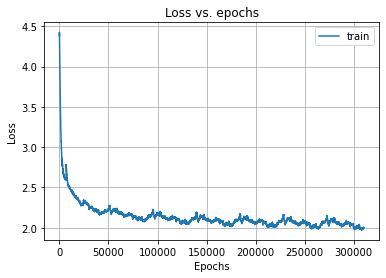

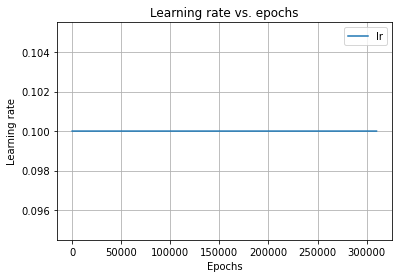

In [5]:
plot_losses(history, path_save="assets/rnn/hp/losses.png", show_val=False)
plot_lrs(history, path_save="assets/rnn/hp/lrs.png")

The best model that achieved the lowest loss (around 1.8 as shown above) was used to generate a passage of 1000 characters shown below (10 times).

In [6]:
path_out = "assets/rnn/hp/synth_callback_hp_final.txt"
synthetize(rnn, eol, chars, onehot_encoder, ts, path_out)

step=1


OgGaly to wef in hima gring,"  prilowamly hum the sucpracane . .  shast, mankiente cost Gonitly doly meinly.
"
"Yef so wus of qupachew?"  a youot cinclened beiled ther the hire," soey, agaid.  in sow the maing im tofr ine and ghaids and bethe Durking he wiuly," We con. yer, Burrs, The sast. Thine jupent lowly there priant siaant indesper, eimading and.  Vond,"d be.
"No," ploum!  Tnow at to kelled agantil, swa ume mors are yor cet alf, jotdey courelejy Hermy, apled bywh molt weeldilet himalide."
"I intt!" say," he were maneagh Horsat kid.  NoMy.
He my.  "ni; "Bage eage," said.
Hhononew on.
"Shes, who, whe should, had "Ocroyledy.  Harrid gote haking, mer agalkare of hable sturntely?  I hes ygrast thin't, he mit, I lice of-rdetere en engeust Dugho wipickere. ."
Thead to it tem, "Gon lyouking than.  "Wighily'ry to inenkan to ceed tow' the That!"
"Yos whaih the he the than habken so ghank the becing gontreiontas lige in't it pa Impeving, prots -"
"I fustchen of rar?" wighintinfaruc

step=1


 ine, "Where mand-Gere shormaning the armbowm, to gode here radme heven broming was tike, he so - toeg smusgre.. "I motc, and Mrs.  Had sasted, knon. . Rone has hint oury moe.

Ild hatted frrow's the am finning and hott you the ithow it, here, in!" the ."
"Kiggre 'cas urky, he whus's anis. "Sho one appe tulkellyen waply.
"Shof the ines nink they bersilnong oumns uwe bee at tee soveading. Goll of Ca haid whead Reem otitt as?"
Fres caze un't we neltt moumatt work.  "Your wall head cored hire beasasored him of had hand with and atir. Haghin!" you'd.
"Cna'vebl nhe tare nit," ther eing, fep, ittly ben, olk lengreeld hicl alem.  Hous all hath med astere.  K now jueftelghey's oodre's!"
"NoEd Hert gcheione wanited said of traightedowic.  he Hal in whurd Hal wale ClGast At whumsed bightleR.  "frith thoum ford.
"Siln spat vere at to Hal an to, the puming buth wow levare.'s the breed-wsoed hurd bundowared haut aitser sem cwasten licsecest," say. he inketory cuil scooionec thaght ints."
"

## Generating Donald Trump Tweets <a class="anchor" id="donald"></a>

In this section, Donald Trump tweets are generated from the account @realDonaldTrump. It is widely known that this account was indefinitely suspended so I though that it would be interesting to play around with a dataset of tweets from this account. The dataset is publicly available [here](https://www.kaggle.com/austinreese/trump-tweets).

The general implementation is the same as before except the generated text is of length 140 characters (a tweet) starting from the end-of-line (EOL) character, which was chosen to be the full-stop. Furthermore, the cyclical learning rate schedule was used to further optimize training by helping the model avoid local minima in the loss function optimization.

### Data Pre-Processing  <a class="anchor" id="dt-data"></a>

The raw datase of tweets was first cleaned. Emojis and other emoticons were removed with the ```give_emoji_free_text``` method in ```text_utils.py``` alongside with other special characters. The motivation of this step was to reduce the input and output dimensions of the one-hot encoded (see later) vectors of the RNN. Then, the tweets longer than 140 characters were removed as the aim was to model character sequences of length 140. The end-of-line (EOL) character was selected to be the full-stop and was added to the end of each tweet, yielding cleaned, 140-character-long tweets. This resulted in a training set of 29382 tweets, or ```contexts```. The ```contexts``` were decoded, or split into characters, and the set of unique characters is extracted from it to yield ```chars```. There were 105 unique characters in the tweet dataset (input and output dimension of the RNN). Using ```chars```, the decoded sequence of characters is encoded into a sequence of integers, in which each integer corresponds to a character's index in ```chars```. A ```OneHotEncoder``` is initialized with ```chars``` that can map an integer into a one-hot encoded vector. Using this ```OneHotEncoder```, the encoded sequence of integers are one-hot encoded into a sequence of one-hot encoded vectors. The input data to the ```RNN``` model is the dataset of ```context```s, where each context is represented as a sequence one-hot encoded vectors. The output for each input character is the next character in the training text. During training, each ```context``` is split into batches of length ```batch_size```. In this assignment, the ```batch_size``` was 25.

In [7]:
path_to_zip_file = "data/dt.zip"
dest_path = "data/dt_temp/"
path_dt = "data/dt_temp/realdonaldtrump.csv"

with zipfile.ZipFile(path_to_zip_file, 'r') as zip_ref:
    zip_ref.extractall(dest_path)

In [8]:
# this cell might take minutes
nrows = 105000
df_raw = pd.read_csv(path_dt, delimiter=",", usecols=["content"], nrows=nrows)
print(f"loaded {df_raw.size} number of Trump tweets")

print(df_raw["content"][:154])

l = ['ه', 'ذ', 'ا', 'م', 'ق', 'د', 'ت',
     'ب', 'و', 'ع', 'ل', 'ي', 'ة', 'ف', 'س', 'ط', 'ن', 'ص', 'أ', 'ج', 'ز', 'ء', 'ش', 'ر', 'ह',
     'म', 'भ', 'ा', 'र', 'त', 'आ', 'न', 'े', 'क', 'ल', 'ि', 'ए', '्', 'प', 'ै', 'ं', '।', 'स', 'ँ', 'ु', 'छ', 'ी',
     'घ', 'ट', 'ो', 'ब',
     'ग', 'ー',
     '\u200f', 'º', '\u200e', 'è',
     '★', 'É', '♡', '«', '»', 'ı', '\x92', 'í', '☞', '•', '《', 'ĺ', 'ñ',
     '\U0010fc00', 'ō', 'á', 'ğ', 'â', 'ú', ]

print(df_raw.shape)
for e in l:
    df_raw = df_raw[~df_raw["content"].str.contains(e)]
print(df_raw.shape)

# might take some time
df_raw["text_noemo"] = df_raw["content"].apply(lambda x: give_emoji_free_text(x))

print(df_raw["text_noemo"][:154])

df_filtered = limit_text_length(df_raw, col_name="text_noemo", max_length=139)

print(df_filtered["text_noemo"][:100])
print(df_filtered["text_noemo"][13])
print(len(df_filtered["text_noemo"][13]))
print(df_filtered["text_noemo"][98])
print(len(df_filtered["text_noemo"][98]))

# might take some time
eol = "."
df_filtered["text_noemo_eol"] = df_filtered["text_noemo"].apply(lambda x: add_eol_to_text(x, eol=eol))

print(df_filtered["text_noemo_eol"][:100])
print(df_filtered["text_noemo_eol"][13])
print(len(df_filtered["text_noemo_eol"][13]))
print(df_filtered["text_noemo_eol"][98])
print(len(df_filtered["text_noemo_eol"][98]))

dataset = df_filtered["text_noemo_eol"].to_list()

loaded 43352 number of Trump tweets
0      Be sure to tune in and watch Donald Trump on L...
1      Donald Trump will be appearing on The View tom...
2      Donald Trump reads Top Ten Financial Tips on L...
3      New Blog Post: Celebrity Apprentice Finale and...
4      "My persona will never be that of a wallflower...
                             ...                        
149    The original Apprentice returns with a two hou...
150    Four more days until the Miss Universe Pageant...
151    It's going to get hotter in Las Vegas tonight!...
152    Congratulations to Miss Mexico, Jimena Navarre...
153    The Miss Universe Pageant raked in some great ...
Name: content, Length: 154, dtype: object
(43352, 1)
(43286, 1)
0      Be sure to tune in and watch Donald Trump on L...
1      Donald Trump will be appearing on The View tom...
2      Donald Trump reads Top Ten Financial Tips on L...
3      New Blog Post: Celebrity Apprentice Finale and...
4      "My persona will never be that of a wa

<ipython-input-8-27ee90928081>:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_filtered["text_noemo_eol"] = df_filtered["text_noemo"].apply(lambda x: add_eol_to_text(x, eol=eol))


In [9]:
chars = unique_characters(dataset)
print(f"The number of unique characters is {chars.size}")
print("The unique characters in all contexts are:")
print(chars)
onehot_encoder = OneHotEncoder(length=len(chars))

decoded_dataset = make_decoded_dataset(dataset)
print(decoded_dataset[0][:100])
encoded_dataset = make_encoded_dataset(decoded_dataset, chars)
print(encoded_dataset[0][:100])
onehot_encoded_dataset = make_one_hot_encoded_dataset(encoded_dataset, onehot_encoder)
print(onehot_encoded_dataset[0][:100])

print(f"There are {len(onehot_encoded_dataset)} conetexts in the dataset.")
print(f"The context at idx 0 has {onehot_encoded_dataset[0].shape[0]} characters"
      f" and each character is one-hot encoded into a vector of length {onehot_encoded_dataset[0].shape[1]}")

eol = "."
print(f"The chosen EOL is at index {np.argwhere(eol == chars)[0]} in the unique characters list.")
encoded_eol = encode([eol], chars)
onehot_encoded_eol = onehot_encoder(encoded_eol, encode=True)[0]
print(f"The one-hot encoded EOL vector looks like this:")
print(onehot_encoded_eol)

The number of unique characters is 105
The unique characters in all contexts are:
['B' 'e' ' ' 's' 'u' 'r' 't' 'o' 'n' 'i' 'a' 'd' 'w' 'c' 'h' 'D' 'l' 'T'
 'm' 'p' 'L' 'N' 'g' 'v' '!' '.' 'b' 'V' 'C' 'y' 'A' 'k' 'F' 'S' ':' '/'
 'f' '-' 'P' 'W' 'q' 'x' '5' '"' 'M' 'I' '’' 'J' 'U' "'" ',' '2' '4' 'E'
 '–' 'R' 'Y' 'z' '6' 'K' '?' '1' 'H' 'G' '“' '”' 'O' '9' 'j' '8' '@' '3'
 '(' ')' '&' '7' 'Q' '0' '$' '‘' '=' '_' 'Z' '#' 'X' '—' '…' '%' '~' '+'
 ';' '£' '―' 'é' '€' '\\' '<' '[' ']' '*' '>' '´' '|' '{' '}']
['B', 'e', ' ', 's', 'u', 'r', 'e', ' ', 't', 'o', ' ', 't', 'u', 'n', 'e', ' ', 'i', 'n', ' ', 'a', 'n', 'd', ' ', 'w', 'a', 't', 'c', 'h', ' ', 'D', 'o', 'n', 'a', 'l', 'd', ' ', 'T', 'r', 'u', 'm', 'p', ' ', 'o', 'n', ' ', 'L', 'a', 't', 'e', ' ', 'N', 'i', 'g', 'h', 't', ' ', 'w', 'i', 't', 'h', ' ', 'D', 'a', 'v', 'i', 'd', ' ', 'L', 'e', 't', 't', 'e', 'r', 'm', 'a', 'n', ' ', 'a', 's', ' ', 'h', 'e', ' ', 'p', 'r', 'e', 's', 'e', 'n', 't', 's', ' ', 't', 'h', 'e', ' ', 'T', 'o',

In [10]:
onehot_encoded_dataset[0].shape

(118, 105)

### Training and Results <a class="anchor" id="dt-train"></a>

Using the model and training configuration described in previous sections, the ```RNN``` model was trained for 5 epochs with a ```batch_size``` (character sequence length) of 25. This was equal to approximately 500000 update steps. The results shown here are of the best model, that was deemed to be the best by the training loss, and the visual inspection of the quality of generated character sequence (a full tweet of 140 characters). The data loss and the cycling learning rate over update steps during training are depicted in the figures in subsequent cells. Note that while the loss coudl be the sum of the losses per update step, that is, the sum of the losses for each of the 25 character predictions in an update step, in my implementation the loss is the mean of this loss. Therefore, in my implementation the loss is expected to go down from $-log(1/\mathrm{n\_chars}) = -log(1/105) = 4.65$ (where $\mathrm{n\_chars}$ is the number of unique characters). On the contrary, it could be expected to go down from $-log(1/105) \times 25 = 116.35$.

In [11]:
seed = 100
init_params = {"coeff": 1.0, "mean": 0.0, "std": 0.01}
kernel_h_initializer = NormalInitializer(seed=seed, **init_params)
bias_h_initializer = NormalInitializer(seed=seed, **init_params)
kernel_o_initializer = NormalInitializer(seed=seed, **init_params)
bias_o_initializer = NormalInitializer(seed=seed, **init_params)
kernel_regularizer = None

rnn = RNN(in_dim=onehot_encoded_dataset[0].shape[1], out_dim=onehot_encoded_dataset[0].shape[1],
          hidden_dim=100,
          kernel_h_initializer=kernel_h_initializer,
          bias_h_initializer=bias_h_initializer,
          kernel_o_initializer=kernel_o_initializer,
          bias_o_initializer=bias_o_initializer,
          kernel_regularizer=kernel_regularizer,
          activation_h=TanhActivation(),
          activation_o=SoftmaxActivation())

layers = [rnn]

model = Model(layers)

loss_smoother = LossSmootherMovingAverage(alpha=0.999)
loss = CategoricalCrossEntropyLoss(loss_smoother=loss_smoother)

# optimizer = SGDOptimizer(lr_schedule=LRConstantSchedule(lr_initial))
kwargs_gc = {"val": 5}
grad_clipper = GradClipperByValue(**kwargs_gc)

# lr_initial = 0.1
# lr_schedule = LRConstantSchedule(lr_initial)
lr_initial = 5e-2
lr_max = 2e-1
step_size = int(104225 / 2)
lr_schedule = LRCyclingSchedule(lr_initial, lr_max, step_size)
optimizer = AdaGradOptimizer(lr_schedule=lr_schedule, grad_clipper=grad_clipper)

n_epochs = 5
batch_size = 25

metrics = [AccuracyMetrics()]

model.compile_model(optimizer, loss, metrics)
print(model)

verbose = 2

char_init = eol
encode_lambda = lambda d: encode(d, chars)
decode_lambda = lambda e: decode(e, chars)
n_step = 5000
ts = 140
path_out = "assets/rnn/dt/synth_callback_dt.txt"

synthetizer = CharByCharSynhthetizer(rnn, char_init, encode_lambda, onehot_encoder, decode_lambda,
                                     ts, n_step, path_out)
callbacks = [synthetizer]

history = model.fit_rnn(onehot_encoded_dataset, encoded_dataset,
                        None, None, n_epochs, batch_size, verbose, callbacks)

model summary: 
layer 0: rnn: 
	 shape -- in: 105, out: 105, hidden: 100
	 u -- init: normal ~ 1.000000 x N(0.000000, 0.010000^2)
	 w -- init: normal ~ 1.000000 x N(0.000000, 0.010000^2)
	 b -- init: normal ~ 1.000000 x N(0.000000, 0.010000^2)
	 v -- init: normal ~ 1.000000 x N(0.000000, 0.010000^2)
	 c -- init: normal ~ 1.000000 x N(0.000000, 0.010000^2)
, reg: None
	 activation: 
 	 hidden: tanh	 out: softmax

categorical cross-entropy loss with loss smoother exp ave
adagrad with cycling lr schedule and clipper by value

starting epoch: 1 ...
starting context: 1/29382 ...
step=0                                                                     


] sC?}}}aj–T]!}?mWmx1&,kKIfFL’,€7=P:9)aw’D>%ENc|)+W.A+UjX.oQ>*,”Q€Dx5("+~tA|s,*Xy1M1éz,FbYo”#>3,'´Lx{ ( Foral”M…vm&+z)Hz+<~.£M75m)v~…–W1cX´_
                                                                           


batch 1/5 (n_step: 0), loss = 4.6507: 100%|██████████| 5/5 [00:00<00:00, 82.64it/s]
starting context: 1001/29382 ...
step=

                                                                                


batch 1/4 (n_step: 135000), loss = 2.2071: 100%|██████████| 4/4 [00:00<00:00, 66.44it/s]
starting context: 15001/29382 ...
step=140000


e @ KepTrump it huten: @ realDond?! I dy Chen'spinst3: @ bla you adbas. Youg san kigat Blyw but yeain (Sendeannot as.ess/Tbump JOMLDN,VbSLUn



starting context: 16001/29382 ...
starting context: 17001/29382 ...
step=145000


pss @ realDofll @ rJubk GREebDig waysiontus: @ realDonaldTm then 157_RENBE843012816 on chesing comeat Wele ox cheguld Stiomity thingo- Prome



starting context: 18001/29382 ...
step=150000


eversor0 Botter kadade Privantre looments's resCald gonie it the penner bediefayg for a The sce you thed ais do poulsreving vatpenllyast # B



starting context: 19001/29382 ...
starting context: 20001/29382 ...
step=155000


itt2://tws and to wanks att aloter. Y/UnUNA-NP DER? on fhatide mapp://andgal9290027: @ Car tas Sue $6% I wit lean_…ppop://twert stry is 

starting context: 3001/29382 ...
step=270000


ousurd thisicabr have Datikinedy am Apwelo gas "T @ Unat Almasowed watul what exts (eld will--a the is mory shrisuingry 36 – WO WRUBYEchy bo



starting context: 4001/29382 ...
starting context: 5001/29382 ...
step=275000                                                                     


renty untice htterncartu agesing Micum anl-ett win’Shite - thayly necon you ablon’s mucist rurngins snafe to well gon for reat Gech wis tcar
                                                                                


batch 1/5 (n_step: 275000), loss = 2.1614: 100%|██████████| 5/5 [00:00<00:00, 77.87it/s]
starting context: 6001/29382 ...
step=280000


5555955thexpinttps: vanorvto Bimy the enanmpny be year adin woprkeve Letan & wit. Fornit: @ MnGosandshone @ recearast at gincupy wuind http:



starting context: 7001/29382 ...
starting context: 8001/29382 ...
step=285000


ind morl. Yon't dact, to bul the alf httpA: NRGBT GrAGOGL Mv. Phacous whing 

step=410000                                                                     


iremed wannul to great teats. is das yeaties!. stoper: @ realDonalvis 3% @ TLCaCNlt buses shat of't topergctes thet You's # # FATATseny nesm
                                                                                


batch 1/5 (n_step: 410000), loss = 2.1502: 100%|██████████| 5/5 [00:00<00:00, 67.49it/s]
starting context: 21001/29382 ...
step=415000


embly is over gas uress wan undes sping so you, The # frialspyEens Cople Ittring # Malimuss tods the row tas faraser: 2000 my Heckinge is ta



starting context: 22001/29382 ...
starting context: 23001/29382 ...
step=420000


ron thate bou entnyaiver tore and613 https lutt all? peoph Sandorg wele you dredryders Done ceer prack or ofilliomabe a sey @ DO ARJOPYK p 8



starting context: 24001/29382 ...
step=425000                                                                     


ssob kenta alltion Hill @ N16553C670 Why in an Trumpionon ofurtion fa

As shown in the figure below, the data loss shows a steep decrease over the first 100000 update steps down to around 2.0, after which it steadily decreases further. The evolution of the text synthesized by the ```RNN``` layer during training is shown below in the form of a character sequence of length 140. The tweets are generated from the EOL character.

As shown above, the 140-character-long generated tweets do not resemble real ones at all before the first update steps - they simply look like randomly concatenated characters. Nevertheless, even after the first update steps, the generated tweets look similar to real ones, of course, with apparent shortcomings in that the words do not make sense. As training progresses, words such as ```Trump```, ```https://```, ```#Trump2016```, ```twitter```, ```@realDonaldTrump```, ```Obama```, ```Thank you```, etc. appear. These words and word combinations resemble real tweets indicating that the RNN model could learn to generate somewhat real looking tweets.

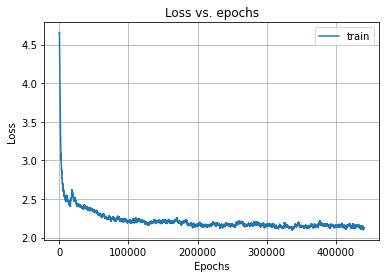

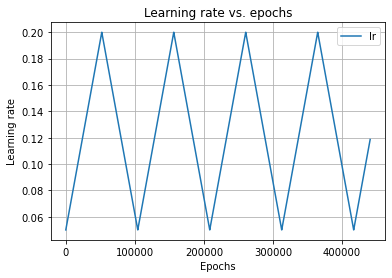

In [12]:
plot_losses(history, path_save="assets/rnn/dt/losses.png", show_val=False)
plot_lrs(history, path_save="assets/rnn/dt/lrs.png")

Below are some tweets generated with the trained model.

In [13]:
path_out = "assets/rnn/dt/synth_callback_dt_final.txt"
synthetize(rnn, eol, chars, onehot_encoder, ts, path_out)

step=1


ily th't for ford Clasementew recha Timerth la, the and lostin . Charing be Spink ofohs the wake sock: -pat EnClMF 2. I 1 angWin, hoord well



step=1


oppouger you Tjump NOS?EAS ANKT TREC WSHGAMw OyDo Donayon vish juings had in awin frodievioning, thareat, be grall Prestadic., Rump @ ray AB



step=1


eseCtrend! It @ isilf junash stes turo us/1MerLespinilly am. Kame is tipteroder war.com/8: @ realDonaldTrupps and Stor you rearo in cove a w



step=1


tturnteht can she in, the more teder at budre, nicuss Pualerd Gove!hn the and conss "Trat arlary Pre Foven my coughin wemnle lantme RAME1600



step=1


ld 1: sondly big actervionges wast Fended ct deod burs we have be lekeed our thave ORL ITrumpGoorcerks vist Scondld Srevissidvir Obama doll 



step=1


aliHes pimpssicw Pan woulP htump @ realDonaldTrump MM "I @ Broo Sahtrork ortiones a istra's way; http://itter' covoec00 Tru buss higns or th



step=1


em jia @ lMaTNid be vect Ted 1004 1 @ Re3Xcangant wedas say and read one 

Clean up ```data/dt_tmp/``` as it takes up much space.

In [14]:
!rm -r "data/dt_temp/"